In [1]:
%%capture
!pip uninstall typing -y
!pip install flair==0.9

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style('darkgrid')

# Named Entity Recognition (NER)

NER is an information extraction technique to identify and classify named entities in text. These entities can be pre-defined and generic like location names, organizations, time and etc, or they can be very specific like the example with the resume.

The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

* B - {CHUNK_TYPE} – for the word in the Beginning chunk
* I - {CHUNK_TYPE} – for words Inside the chunk
* O – Outside any chunk

The IOB tags are further classified into the following classes –

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

## Approaches to NER
* **Classical Approaches:** mostly rule-based.
* **Machine Learning Approaches:** there are two main methods in this category: 
    * Treat the problem as a multi-class classification where named entities are our labels so we can apply different classification algorithms. The problem here is that identifying and labeling named entities require thorough understanding of the context of a sentence and sequence of the word labels in it, which this method ignores that.
    * Conditional Random Field (CRF) model. It is a probabilistic graphical model that can be used to model sequential data such as labels of words in a sentence. The CRF model is able to capture the features of the current and previous labels in a sequence but it cannot understand the context of the forward labels; this shortcoming plus the extra feature engineering involved with training a CRF model, makes it less appealing to be adapted by the industry.
* **Deep Learning Approaches:** Bidirectional RNNs

# EDA

In [3]:
data = pd.read_csv(
    "../input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False, 
    usecols=['sentence_idx', 'word', 'tag']
)
data  = data[data['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)
data['sentence_idx'] = data['sentence_idx'].apply(int)
print(data.shape)
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1050794, 3)


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


Number of Sentences: 35177
Maximum sequence length: 140
Number of unique words: 30172


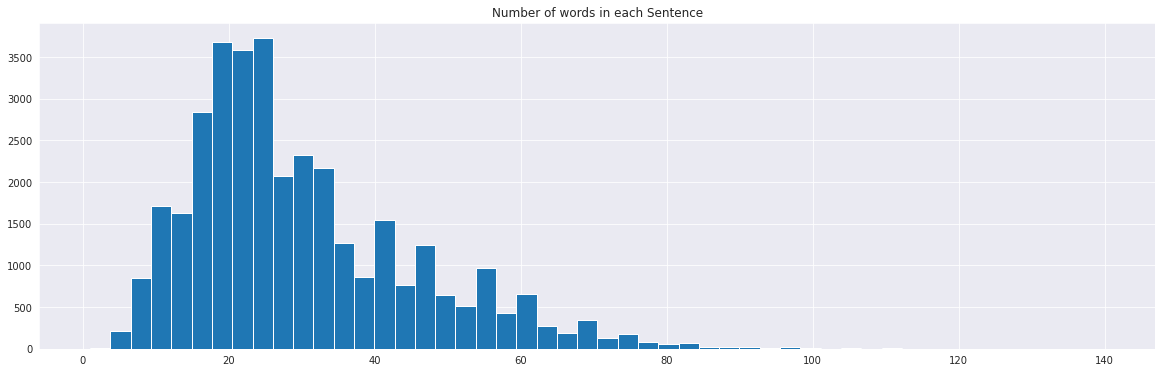

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(data['sentence_idx'].value_counts().values, bins=50)
ax.set_title('Number of words in each Sentence')

maxlen = np.max(data['sentence_idx'].value_counts().values)
print('Number of Sentences:', data['sentence_idx'].nunique())
print ('Maximum sequence length:', maxlen)

words = list(set(data["word"].values))
n_words = len(words)
print('Number of unique words:', n_words)

Number of unique Tags: 17


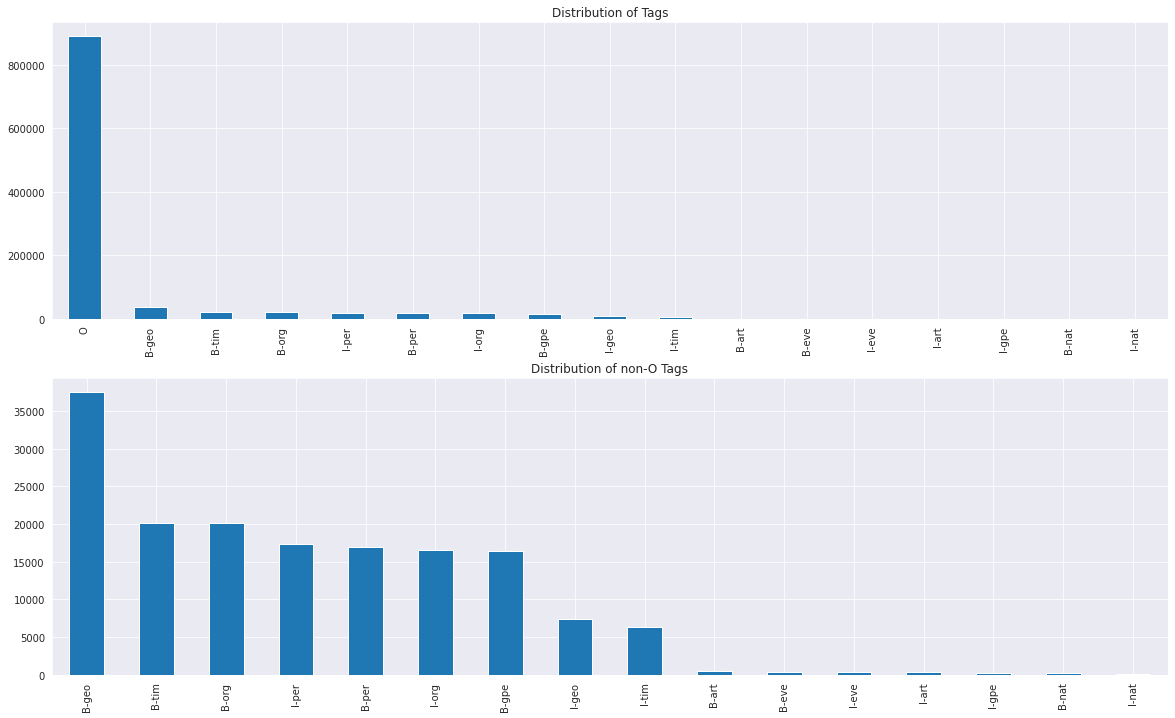

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
data.tag.value_counts().plot.bar(ax=ax[0], title='Distribution of Tags')
data[data.tag != 'O'].tag.value_counts().plot.bar(ax=ax[1], title='Distribution of non-O Tags')

tags = list(set(data["tag"].values))
n_tags = len(tags)
print('Number of unique Tags:', n_tags)

# Preprocessing

In [6]:
mask = data['sentence_idx'].ne(data['sentence_idx'].shift(-1))
data1 = pd.DataFrame('',index=mask.index[mask] + .5, columns=data.columns)

data = pd.concat([data, data1]).sort_index().reset_index(drop=True).iloc[:-1]
data[['word', 'tag']].to_csv('data.txt', sep=' ', index=False, header=False)
data.head(30)

,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O
5,1,through,O
6,1,London,B-geo
7,1,to,O
8,1,protest,O
9,1,the,O


# Modelling

In [7]:
from flair.data import Corpus, Sentence
from flair.datasets import ColumnCorpus
from flair.embeddings import WordEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from typing import List

In [8]:
columns = {0 : 'text', 1 : 'tag'}
data_folder = '/kaggle/working'

corpus: Corpus = ColumnCorpus(data_folder, columns, train_file = 'data.txt')

2022-10-29 08:52:59,284 Reading data from /kaggle/working
2022-10-29 08:52:59,285 Train: /kaggle/working/data.txt
2022-10-29 08:52:59,286 Dev: None
2022-10-29 08:52:59,287 Test: None


In [9]:
tag_type = 'tag'
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

In [10]:
embedding_types : List[TokenEmbeddings] = [WordEmbeddings('glove')]
embeddings : StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

2022-10-29 08:53:17,564 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpv1__1_d4


100%|██████████| 160000128/160000128 [00:04<00:00, 36503229.91B/s]

2022-10-29 08:53:22,114 copying /tmp/tmpv1__1_d4 to cache at /root/.flair/embeddings/glove.gensim.vectors.npy
2022-10-29 08:53:22,288 removing temp file /tmp/tmpv1__1_d4


2022-10-29 08:53:22,482 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpxgls8595


100%|██████████| 21494764/21494764 [00:00<00:00, 35022917.76B/s]

2022-10-29 08:53:23,269 copying /tmp/tmpxgls8595 to cache at /root/.flair/embeddings/glove.gensim
2022-10-29 08:53:23,298 removing temp file /tmp/tmpxgls8595


In [11]:
tagger : SequenceTagger = SequenceTagger(
    hidden_size=256, embeddings=embeddings, tag_dictionary=tag_dictionary, 
    tag_type=tag_type, use_crf=True
)
print(tagger)

SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=100, out_features=100, bias=True)
  (rnn): LSTM(100, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=20, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)


In [12]:
trainer : ModelTrainer = ModelTrainer(tagger, corpus)
trainer.train('model', learning_rate=0.1, mini_batch_size=32, max_epochs=15)

2022-10-29 08:53:29,451 ----------------------------------------------------------------------------------------------------
2022-10-29 08:53:29,452 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=100, out_features=100, bias=True)
  (rnn): LSTM(100, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=20, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2022-10-29 08:53:29,453 ----------------------------------------------------------------------------------------------------
2022-10-29 08:53:29,454 Corpus: "Corpus: 38947 train + 4328 dev + 4808 test sentences"
2022-10-29 08:53:29,455 ----------------------------------------------------------------------------------------------------
2022-10-29 08:53:29,456 Parameters:
2022-10-29 08:53:29,457  - learni

{'test_score': 0.8026410998552822,
 'dev_score_history': [0.7334781917430706,
  0.7677969671440606,
  0.7768363050371678,
  0.7910667955435722,
  0.7860455737043758,
  0.7963900726999247,
  0.7949001104306797,
  0.801228167312629,
  0.800636975394257,
  0.8094923522536713,
  0.8050881816338942,
  0.8091456320501795,
  0.8096847414880202,
  0.8089740357953114,
  0.8080148646612765],
 'train_loss_history': [0.3145581403008123,
  0.20273664403324168,
  0.18102583892129,
  0.1688068945311955,
  0.16189696742324727,
  0.15696338804227528,
  0.15318389416734884,
  0.14986303789887928,
  0.14737668103761614,
  0.14547155659231642,
  0.1438866057395162,
  0.14281666999373144,
  0.14142348921112438,
  0.1400354316857311,
  0.13968781860646165],
 'dev_loss_history': [tensor(0.1469, device='cuda:0'),
  tensor(0.1179, device='cuda:0'),
  tensor(0.1095, device='cuda:0'),
  tensor(0.1005, device='cuda:0'),
  tensor(0.0966, device='cuda:0'),
  tensor(0.0955, device='cuda:0'),
  tensor(0.0922, device=

In [13]:
model = SequenceTagger.load('model/final-model.pt')

sentence = Sentence('I love India')

model.predict(sentence)
print(sentence.to_tagged_string())

2022-10-29 09:20:58,273 loading file model/final-model.pt
I love India <B-geo>
